# Scraping book metadata from Biblissima

## What are we doing?

There is a wealth of data available on the Internet that is not immediately downloadable through conventional methods. *Web scraping* provides us with a way to programmatically extract important research data, where appropriate, from almost any website.

In this example, we will be looking at how to extract search results from *Biblissima*: https://iiif.biblissima.fr/collections/about.

## What python packages do we need and why?

For this exercise we will be using three python packages:

1. *requests* will allow us to fetch HTML from the Biblissima website.
2. *BeautifulSoup* will allow us to extract relevant metadata from this HTML.
3. *pandas* will let us create a table of our results and export these to a CSV.

Note how the individual python packages all have a specific responsibility within our script. Once you learn the basics of a programming language, the next step is to become familiar with existing packages that will help you get get your work done faster:

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

## Where is the data?

We will be getting data from this set of search results: https://iiif.biblissima.fr/collections/search?q=Descartes&sliderDateleft=1596&sliderDateright=1650&from=0

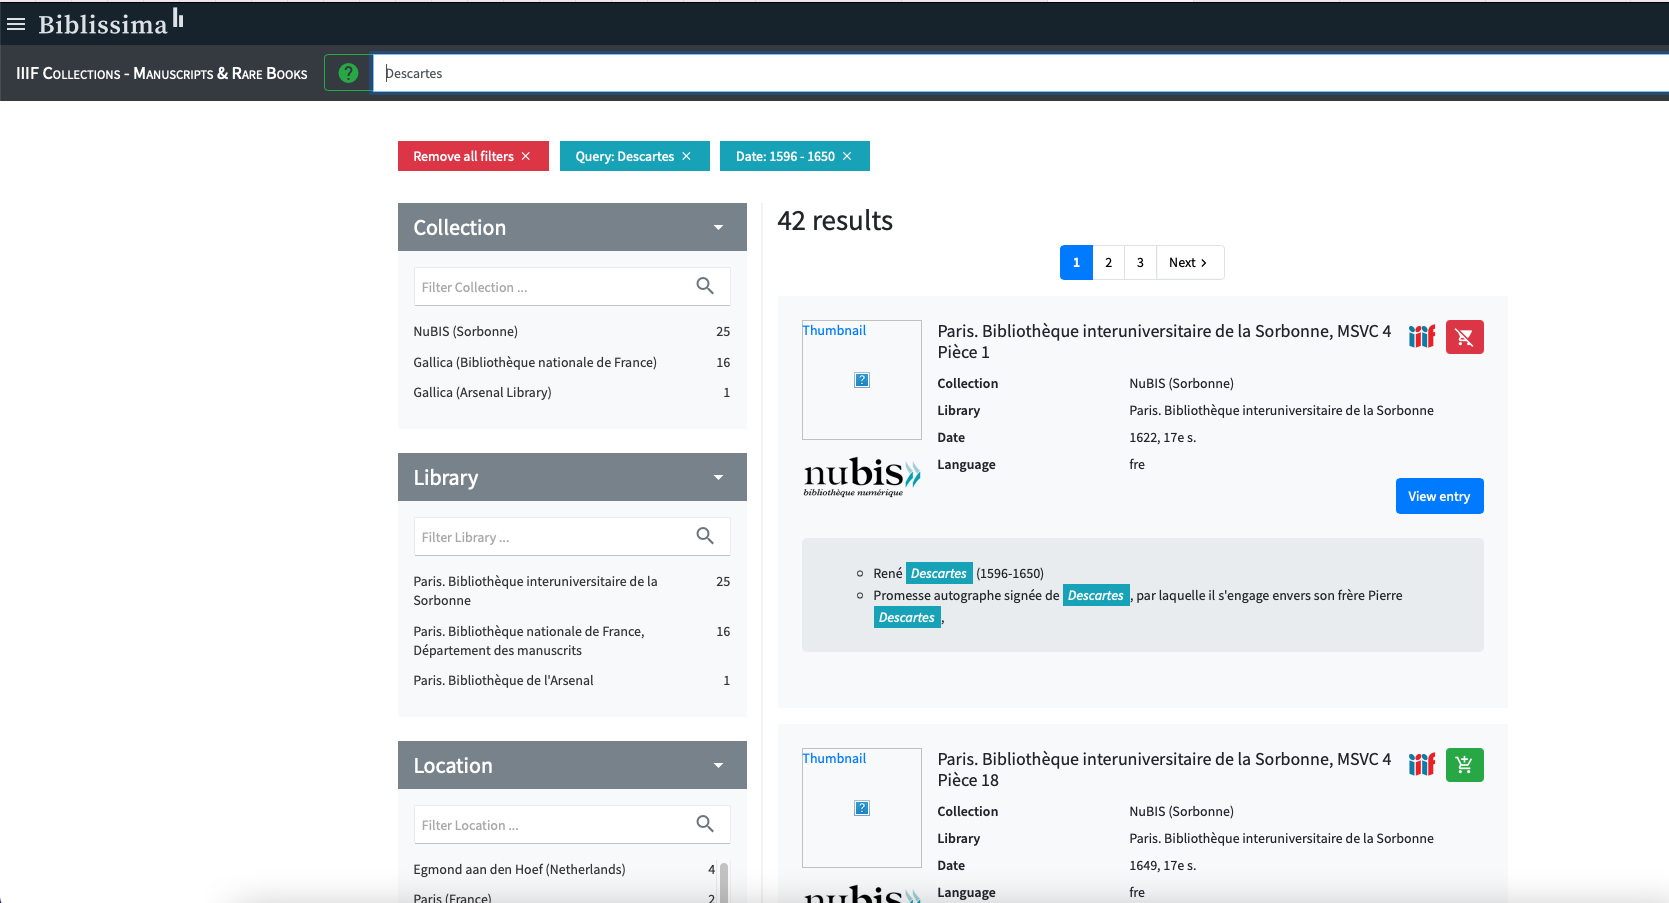

It is worth spending a moment to look at the different components of the URL:

In [9]:
SEARCH_URL = "https://iiif.biblissima.fr/collections/search?q=Descartes&sliderDateleft=1596&sliderDateright=1650&from=0"

## How do we get the raw HTML and what does it look like?

The following cell fetches the HTML from our search URL:

In [10]:
page_html = requests.get(SEARCH_URL).text

Let's look at the first thousand characters of the HTML we just fetched from the web:

In [11]:
print(page_html[:1000])

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <!-- CSRF Token -->
    <meta name="csrf-token" content="m47LzInLfmSkicF6MUlyZTz7GZ6e6OkG1rzru4Sr">

        <title>42 results found for &quot;Descartes&quot; | IIIF Collections of Manuscripts and Rare Books</title>
        <meta name="description" content="A Biblissima prototype to search for interoperable digitized manuscripts and rare books across IIIF-compliant digital libraries">

    <!-- Favicons -->
    <link rel="apple-touch-icon-precomposed" href="https://static.biblissima.fr/images/favicons/apple-touch-icon-152x152.png">
    <meta name="msapplication-TileColor" content="#ffffff">
    <meta name="msapplication-TileImage" content="https://static.biblissima.fr/images/favicons/mstile-144x144.png">
    <link rel="icon" type="image/png" href="https://static.biblissima.fr/images/favicons/favicon.png">
    <!--[if IE]><link rel="shortcut ico

We can also check the length, in characters, of the HTML page:

In [12]:
len(page_html)

120493

## How do we find specific elements on the page?

Clearly our HTML is too long for us to find anything too useful without some additional help. *Beautiful Soup* gives us that help by letting us search for specific elements on the page, but first of all we need to feed it our HTML. By convention, we call the resultant variable `soup`, but we could call this anything: 

In [13]:
soup = BeautifulSoup(page_html)

Our search URL gives us a *list* of *results*. Thankfully, the HTML that underpins this page corresponds accordingly. We can find what we need by searching for `li` or list item elements. You can read more about these here: https://www.w3schools.com/tags/tag_li.asp

In [14]:
results_on_page = soup.find_all("li", {"class": "result"})

The above gives us **all** of the results, but to extract anything useful, we must first understand the structure of a **single** result:

Look carefully at the output below, and try to locate information that we might want to extract. Even if you are not familiar with HTML, you should notice that there are some recurrent patterns:

In [15]:
print(results_on_page[0].prettify())

<li class="result media p-4 mb-3 cart-item" data-id="4f7c1e3bd453d9d2d5004fc4183645b7013ae5fd" data-manifest="https://nubis.univ-paris1.fr/iiif/2/1t5f/manifest" data-shelfmark="Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 1" data-thumbnail="https://nubis.univ-paris1.fr/files/medium/BIS_00_00452_P000_0001.jpg">
 <a href="manifest/4f7c1e3bd453d9d2d5004fc4183645b7013ae5fd">
  <img alt="Thumbnail" class="mr-3" src="https://nubis.univ-paris1.fr/files/medium/BIS_00_00452_P000_0001.jpg"/>
  <img alt="NuBIS (Sorbonne)" class="logo mr-3 mt-3" src="https://nubis.univ-paris1.fr/files/asset/8a3f5215a39ae5dc9f42a546356e0924b534a0ac.png"/>
 </a>
 <div class="media-body">
  <div class="title-container d-flex justify-content-between">
   <h5 class="">
    Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 1
   </h5>
   <div class="d-flex">
    <a class="iiif-logo" href="https://nubis.univ-paris1.fr/iiif/2/1t5f/manifest?iiif-content=https://nubis.univ-paris1.fr/i

For now, let's extract just the title and language for each entry. We'll start with a single example result:

In [16]:
example_entry = results_on_page[0]

We can get the *title* for a result by leverage a label in the HTML called *title-container*:

In [24]:
title = example_entry.find("div", {"class": "title-container"}).text.strip()

Similarly, we can find the language by looking for an element containing the text "Language":

In [25]:
example_entry.find("dt", text="Language").find_next("dd").text.strip()

'fre'

Because we have to repeat this operation for every entry on the page, it might be useful to create a reusable function. Our function takes in a single result, and spits out its title and language:

In [26]:
def get_entry_data(entry):
    
    title = entry.find("div", {"class": "title-container"}).text.strip()
    language = entry.find("dt", text="Language").find_next("dd").text.strip()
    
    return {
        "title": title,
        "language": language,
    }

We can now pass every result on the page into this function, collecting the title and language information:

In [20]:
page_entries_data = []

for entry in results_on_page:
    entry_data = get_entry_data(entry)
    page_entries_data.append(entry_data)

In [21]:
page_entries_data

[{'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 1\n\nadd_shopping_cart',
  'language': 'fre'},
 {'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 18\n\nadd_shopping_cart',
  'language': 'fre'},
 {'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 5\n\nadd_shopping_cart',
  'language': 'fre'},
 {'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 4\n\nadd_shopping_cart',
  'language': 'fre'},
 {'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 11\n\nadd_shopping_cart',
  'language': 'fre'},
 {'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 6\n\nadd_shopping_cart',
  'language': 'fre'},
 {'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 8\n\nadd_shopping_cart',
  'language': 'fre'},
 {'title': 'Paris. Bibliothèque interuniversitaire de la Sorbonne, MSVC 4 Pièce 3\n\nadd_shopping_cart',
  'l

While this is OK, we might want a table that we can export to a CSV file. *Pandas* can help us out here:

In [22]:
pandas_table = pd.DataFrame(page_entries_data)
pandas_table

title  \
0   Paris. Bibliothèque interuniversitaire de la S...   
1   Paris. Bibliothèque interuniversitaire de la S...   
2   Paris. Bibliothèque interuniversitaire de la S...   
3   Paris. Bibliothèque interuniversitaire de la S...   
4   Paris. Bibliothèque interuniversitaire de la S...   
5   Paris. Bibliothèque interuniversitaire de la S...   
6   Paris. Bibliothèque interuniversitaire de la S...   
7   Paris. Bibliothèque interuniversitaire de la S...   
8   Paris. Bibliothèque interuniversitaire de la S...   
9   Paris. Bibliothèque interuniversitaire de la S...   
10  Paris. Bibliothèque interuniversitaire de la S...   
11  Paris. Bibliothèque interuniversitaire de la S...   
12  Paris. Bibliothèque interuniversitaire de la S...   
13  Paris. Bibliothèque interuniversitaire de la S...   
14  Paris. Bibliothèque interuniversitaire de la S...   
15  Paris. Bibliothèque interuniversitaire de la S...   
16  Paris. Bibliothèque interuniversitaire de la S...   
17  Paris. Bibliothèque interuniversitaire de la S...   
18     Paris. Bibliothèque de l'Arsenal, Ms-5410-5427   
19  Paris. Bibliothèque nationale de France, Dépar...   

                              language  
0                                  fre  
1                                  fre  
2                                  fre  
3                                  fre  
4                                  fre  
5                                  fre  
6                                  fre  
7                                  fre  
8                                  fre  
9                                  lat  
10                                 fre  
11                                 fre  
12                                 lat  
13                                 fre  
14                                 fre  
15                                 fre  
16                                 fre  
17                                 fre  
18  français, latin, italien, espagnol  
19                            français

Now let's export this for later use:

In [23]:
pandas_table.to_csv("descartes_results_page_one.csv")

# Questions

- How would we approach getting more data? Look carefully at the search URL at the top of this page.
- How would you approach extracting additional fields?
- How might we start to programmatically access further book metadata available after clicking **View entry**?